In [1]:
!pip install pycocotools

In [2]:
!pip install tensorflow-addons

Check files present in the private preprocessed dataset

In [3]:
import os

dataset_path = "/kaggle/input/hubmap-preprocessed-data/my-hubmap-hacking-the-human-vasculature-dataset-old-combined/coco_data"

# List all files in the dataset
files = os.listdir(dataset_path)
print("Files in dataset:", files)

Files in dataset: ['coco_data.json', 'coco_test_data.json', 'data', 'coco_train_data.json', 'test', 'train']


Load all images

In [4]:
import os
import json
from pycocotools.coco import COCO

# point to COCO dataset and annotations file
coco_path = "/kaggle/input/hubmap-preprocessed-data/my-hubmap-hacking-the-human-vasculature-dataset-old-combined/coco_data"
annotations_file = os.path.join(coco_path, "coco_data.json")  # Change this if your JSON has a different name

# load COCO annotations
coco = COCO(annotations_file)

# get all image IDs
image_ids = coco.getImgIds()
print("Total Images:", len(image_ids))

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Total Images: 422


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils
from pycocotools import mask as maskUtils

Load one sample image and its mask

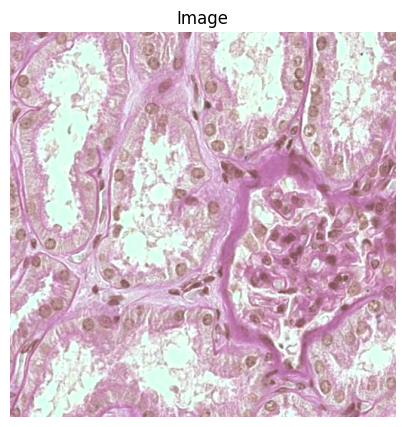

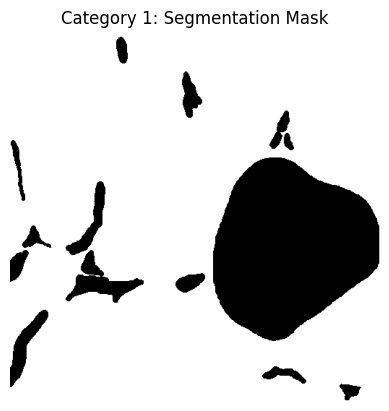

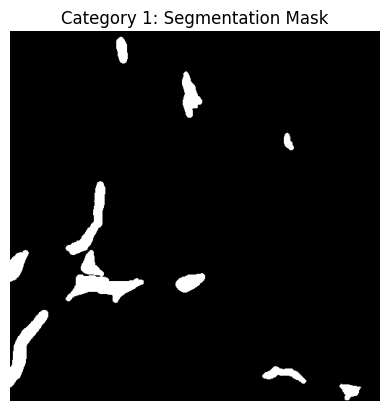

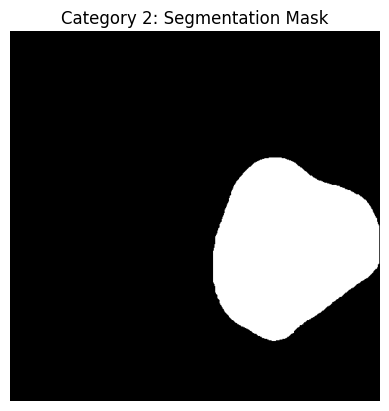

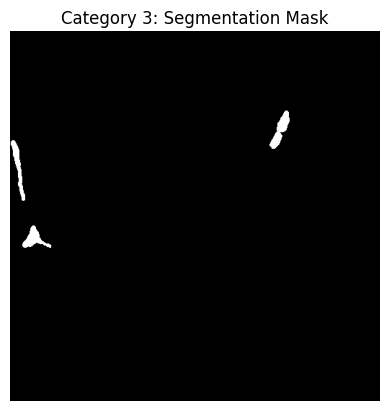

In [6]:


IMAGE_SIZE = 512  # Resize images

def load_image(image_id):
    """loads an image from COCO dataset and resize it"""
    coco_path = "/kaggle/input/hubmap-preprocessed-data/my-hubmap-hacking-the-human-vasculature-dataset-old-combined/coco_data/data"
    image_info = coco.loadImgs(image_id)[0]

    image_path = os.path.join(coco_path, image_info["file_name"])  
    # loads the image in color mode (ignoring transparency).
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 256 for experimentation
    
    return image



def create_binary_mask(image_id, height=512, width=512, selected_classes=[0,1,2]):
    """
    Create a binary mask for a given image ID and selected classes.
    """
    mask = np.zeros((height, width, len(selected_classes)), dtype=np.uint8)  # Multi-channel binary mask

    # Get all annotations for this image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        category_id = ann["category_id"]
        if category_id in selected_classes:  # Only process selected classes
            
            class_index = selected_classes.index(category_id)  # Get channel index
            segmentation = ann["segmentation"]

            # Convert segmentation to mask
            rle = maskUtils.frPyObjects(segmentation, height, width)
            binary_mask = maskUtils.decode(rle).sum(axis=2).astype(np.uint8)


            # Assign to the correct channel
            mask[:, :, class_index] = np.maximum(mask[:, :, class_index], binary_mask)



    return mask  # Shape: (height, width, 3)



def preprocess_mask(binary_mask, target_size=(512, 512)):
    """
    Resize binary masks to a fixed target size.
    """
    resized_mask = np.zeros((*target_size, binary_mask.shape[-1]), dtype=np.uint8)
    
    for i in range(binary_mask.shape[-1]):  # Resize each class separately
        resized_mask[:, :, i] = cv2.resize(binary_mask[:, :, i], target_size, interpolation=cv2.INTER_NEAREST)

    return resized_mask

def convert_to_one_hot(binary_mask):
    """
    Convert a binary mask (H, W, C) into a one-hot encoded mask (H, W, num_classes+1).
    Background is treated as class 0.
    """
    num_classes = binary_mask.shape[-1] + 1  # Include background
    one_hot_mask = np.zeros((*binary_mask.shape[:2], num_classes), dtype=np.uint8)

    for i in range(binary_mask.shape[-1]):  # Assign each class a different label
        one_hot_mask[:, :, i+1] = binary_mask[:, :, i]  # Shift by 1 to reserve background (0)
        one_hot_mask[:, :, 0] += binary_mask[:, :, i] 
    one_hot_mask[:, :, 0] = 1 - one_hot_mask[:, :, 0]
    return one_hot_mask

def load_mask(image_id,height=512, width=512, selected_classes=[0,1,2]):
    # Create binary mask
    binary_mask = create_binary_mask(image_id,height, width, selected_classes)
    binary_mask_resized = preprocess_mask(binary_mask,(height, width))
    one_hot_mask = convert_to_one_hot(binary_mask_resized)
    return one_hot_mask



image_ids = coco.getImgIds()

# load sample image and mask
sample_id = image_ids[248]

sample_image = load_image(sample_id)

sample_mask = load_mask(sample_id)


# display Image & Mask
plt.figure(figsize=(10, 5))

plt.imshow(sample_image)
plt.axis("off")
plt.title("Image")
plt.show()

plt.imshow(sample_mask[:,:,0], cmap="gray")
plt.axis("off")
plt.title("Category 0: Segmentation Mask")
plt.show()

plt.imshow(sample_mask[:,:,1], cmap="gray")
plt.axis("off")
plt.title("Category 1: Segmentation Mask")
plt.show()

plt.imshow(sample_mask[:,:,2], cmap="gray")
plt.axis("off")
plt.title("Category 2: Segmentation Mask")
plt.show()

plt.imshow(sample_mask[:,:,3], cmap="gray")
plt.axis("off")
plt.title("Category 3: Segmentation Mask")



plt.show()

Load Train data

In [7]:
X_train = np.array([load_image(img_id) for img_id in image_ids[:420]])  # Load first 500 images
Y_train = np.array([load_mask(img_id) for img_id in image_ids[:420]])
print("Image Data Shape:", X_train.shape)
print("Mask Data Shape:", Y_train.shape)

Image Data Shape: (420, 512, 512, 3)
Mask Data Shape: (420, 512, 512, 4)


In [8]:
print("Any NaN in X_train?", np.isnan(X_train).any())
print("Any NaN in Y_train?", np.isnan(Y_train).any())
print("Unique values in Y_train:", np.unique(Y_train))

Any NaN in X_train? False
Any NaN in Y_train? False
Unique values in Y_train: [  0   1 255]


Create model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout

def unet_model(input_size=(512, 512, 3), num_classes=4):  # 3 classes + background
    inputs = Input(input_size)

    # Encoder (Downsampling Path)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder (Upsampling Path)
    up6 = UpSampling2D(size=(2, 2))(drop5)
    merge6 = Concatenate()([drop4, up6])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output Layer: Softmax for Multi-Class Segmentation
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

# Initialize U-Net for 3-Class Segmentation
model = unet_model(num_classes=4)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,379,140 (119.70 MB)

 Trainable params: 31,379,140 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Integrate mAP as metric

In [10]:
import tensorflow as tf

def iou_metric(y_true, y_pred, smooth=1e-6, num_classes=4):
    """
    Compute IoU for multi-class segmentation.
    """
    y_pred = tf.argmax(y_pred, axis=-1)  # Convert softmax probabilities to class index
    y_true = tf.argmax(y_true, axis=-1)  # Convert one-hot labels to class index

    # Ensure both tensors are int64
    y_true = tf.cast(y_true, tf.int64)
    y_pred = tf.cast(y_pred, tf.int64)

    ious = []
    for i in range(num_classes):  # Compute IoU for each class
        intersection = tf.reduce_sum(tf.cast((y_pred == i) & (y_true == i), tf.float32))
        union = tf.reduce_sum(tf.cast((y_pred == i) | (y_true == i), tf.float32))
        iou = (intersection + smooth) / (union + smooth)
        ious.append(iou)

    return tf.reduce_mean(tf.stack(ious))  # Compute average IoU


In [11]:
class CheckNaNLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and (np.isnan(logs["loss"]) or np.isnan(logs["val_loss"])):
            print(f"\n🚨 NaN detected in loss at epoch {epoch+1}! Stopping training.")
            self.model.stop_training = True  # Stop training if NaN appears

nan_checker = CheckNaNLoss()

In [12]:
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    #optimizer=Adam(learning_rate=0.001, clipnorm=1.0), 
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", iou_metric]
)

In [14]:
!rm -rf /kaggle/working/*

Call back to save weights every epoch

In [15]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_model_iou.weights.h5",
    monitor="val_iou_metric",  # Track IoU instead of loss
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save weights only (faster)
    mode="max",
    verbose=1
)

In [16]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=4, validation_split=0.2, callbacks=[nan_checker,checkpoint_callback])

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5733 - iou_metric: 0.1447 - loss: 5493.6924

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-16-5971210a4122>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 345, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.73 = (f32[12,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,192,512,512]{3,2,1,0} %concatenate.7, f32[64,192,3,3]{3,2,1,0} %transpose.41, f32[64]{0} %arg35.36), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_16_1/convolution" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 822083584 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_9232]

In [ ]:
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
# import json

# # Load ground truth annotations
# coco_gt = COCO("path/to/ground_truth.json")

# # Load predicted annotations
# coco_dt = coco_gt.loadRes("path/to/predictions.json")

# # Create COCO evaluator
# coco_eval = COCOeval(coco_gt, coco_dt, "segm")  # Use "bbox" for object detection

# # Run evaluation
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
One-Hot Encoded Mask Shape: (1, 512, 512, 4)


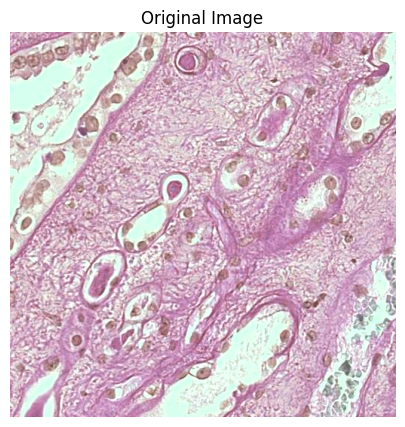

Indices where binary mask is 1:
 [[  1 510]
 [  3   1]
 [  5   1]
 [  6   1]
 [  7   1]
 [  9   1]
 [ 10   1]
 [ 14   1]
 [ 15   1]
 [ 17   1]
 [ 18   1]
 [ 21   1]
 [ 22   1]
 [ 24   1]
 [ 34   1]
 [ 42   1]
 [ 59   1]
 [ 60   1]
 [ 69   1]
 [ 70   1]
 [104   1]
 [107   1]
 [108   1]
 [113   1]
 [114   1]
 [115   1]
 [116   1]
 [117   1]
 [137   1]
 [146   1]
 [164   1]
 [165   1]
 [180   1]
 [181   1]
 [182   1]
 [205   1]
 [206   1]
 [254   1]
 [255   1]
 [256   1]
 [257   1]
 [258   1]
 [259   1]
 [293   1]
 [296   1]
 [297   1]
 [306   1]
 [308   1]
 [309   1]
 [316   1]
 [320   1]
 [327   1]
 [328   1]
 [329   1]
 [356   1]
 [361   1]
 [362   1]
 [367   1]
 [372   1]
 [382   1]
 [383   1]
 [385   1]
 [386   1]
 [393   1]
 [394   1]
 [395   1]
 [396   1]
 [406   1]
 [416   1]
 [417   1]
 [418   1]
 [419   1]
 [424   1]
 [425   1]
 [445   1]
 [450   1]
 [459   1]
 [460   1]
 [465   1]
 [499   1]
 [503   1]
 [508   1]
 [509   1]
 [510   1]]


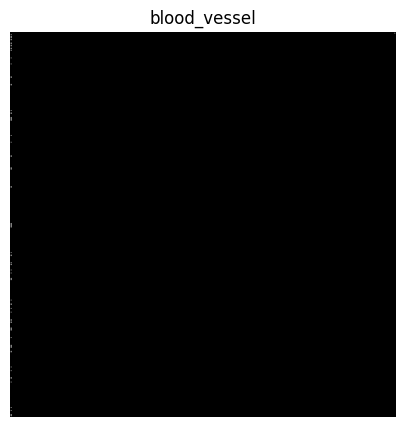

[0 1]


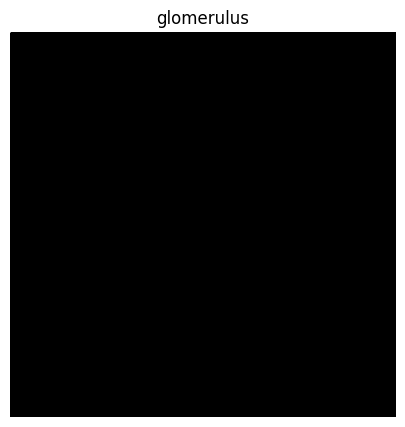

[0]


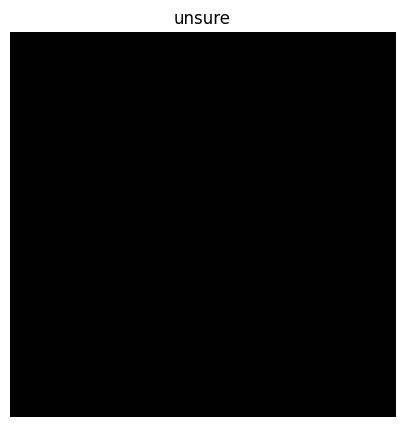

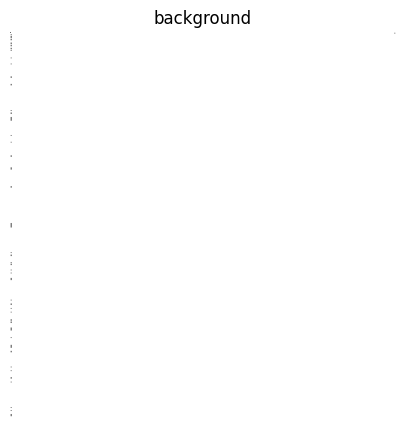

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Select a test image
test_img = load_image(image_ids[421])
test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(test_img)

class_index_mask = tf.argmax(predicted_mask, axis=-1) 

num_classes = 4  # Total number of classes


# Convert to one-hot encoding (shape: H x W x num_classes)
binary_mask = tf.one_hot(class_index_mask, depth=num_classes, axis=-1, dtype=tf.uint8)

print("One-Hot Encoded Mask Shape:", binary_mask.shape)  # Expected: (H, W, num_classes)

# Display the image and predicted mask
plt.figure(figsize=(10, 5))

plt.imshow(load_image(image_ids[421]))  # Original image
plt.axis("off")
plt.title("Original Image")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
# print(f"{np.unique(binary_mask[0,:,:,1])}")
# indices = np.argwhere(binary_mask[0,:,:,1] == 1)

print("Indices where binary mask is 1:\n", indices)
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,1], cmap="gray") 
plt.axis("off")
plt.title("blood_vessel")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
print(f"{np.unique(binary_mask[0,:,:,2])}")
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,2], cmap="gray") 
plt.axis("off")
plt.title("glomerulus")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
print(f"{np.unique(binary_mask[0,:,:,3])}")
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,3], cmap="gray") 
plt.axis("off")
plt.title("unsure")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,0], cmap="gray") 
plt.axis("off")
plt.title("background")

plt.show()
